# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [56]:
# Import necessary libraries
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, root_mean_squared_error
# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Model Choice

Since a simple but strong characteristic of the dataset is the seasonality, we desided here to only consider the mean climatology as baseline model.
In a second baseline model we desided to take seasonal ARIMA since it dynamically includes the season.

## Feature Selection

For the seasonality in the dataset only the timeseries itselve is taken. So we don't take any features for the baselinemodel.

In [59]:


# Load the data as done in #data_characteristics

url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# make time nicer
df['time'] = pd.to_datetime(df[['year','month','day']]) #make a nicer date
df = df.set_index('time')

#features: seasons, decade, more decades?

#seasons
#winter: 11-4 (positiv), summer: 5-10 (negativ) -> defined like this by looking in the seasonality
# Define winter and summer using +1 / -1
winter_months = {11, 12, 1, 2, 3, 4}
df['season_flag'] = df['month'].apply(lambda m: 1 if m in winter_months else -1)
# Put 'season_flag' right after 'month'
df.insert(3, 'season_flag', df.pop('season_flag'))


#decade
df['decade'] = df['year'] // 10 * 10
df.insert(4, 'decade', df.pop('decade'))

# drop day, year
df.drop(columns=['day', 'year'], inplace=True)

#make xarray out of this
ds = xr.Dataset.from_dataframe(df)

# Handling missing values

#fill NaNs with mean of theire neighboring values

def fill_nans_weighted(ds, dim, n=3, weights=None):
    """
    Fill NaNs in an xarray Dataset/DataArray using a weighted mean of
    n values before and after along dimension `dim`.

    Parameters
    ----------
    ds : xr.DataArray or xr.Dataset
        Input data with NaNs to fill.
    dim : str
        Dimension along which to apply the interpolation (e.g. "time").
    n : int
        Number of values before and after to use.
    weights : array-like or None
        Weights for the window. Should have length (2*n + 1).
        If None, all weights = 1 (simple mean).

    Returns
    -------
    xr.DataArray or xr.Dataset
        Data with NaNs filled.
    """

    window = 2 * n + 1

    # default: equal weights
    if weights is None:
        weights = np.ones(window)
    else:
        weights = np.asarray(weights)
        if len(weights) != window:
            raise ValueError("weights must have length 2*n + 1")

    # Normalize weights
    weights = weights / weights.sum()

    # Rolling window with centered window
    rolled = ds.rolling({dim: window}, center=True).construct("window")

    # Weighted mean ignoring NaNs
    filled = (rolled * xr.DataArray(weights, dims=["window"])).sum("window")

    # Replace NaNs only
    return ds.fillna(filled)

ds = fill_nans_weighted(ds, dim='time', n=3, weights=None)


In [60]:
#true monthly, no rolling mean
ds_monthly = ds.resample(time='M').mean()
df_monthly = ds_monthly.to_dataframe()
df_monthly

/usr/local/lib/python3.12/dist-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


,month,season_flag,decade,nao_index_cdas
time,,,,
1950-01-31,1.0,1.0,1950.0,0.463516
1950-02-28,2.0,1.0,1950.0,0.420714
1950-03-31,3.0,1.0,1950.0,0.008387
1950-04-30,4.0,1.0,1950.0,0.239433
1950-05-31,5.0,-1.0,1950.0,-0.261226
...,...,...,...,...
2025-08-31,8.0,-1.0,2020.0,0.184688
2025-09-30,9.0,-1.0,2020.0,-0.373873
2025-10-31,10.0,-1.0,2020.0,-0.398225


In [61]:
#train and test split, here 90/10
n_train = int(0.9 * len(df_monthly))
train = df_monthly.iloc[:n_train]
test  = df_monthly.iloc[n_train:]

In [30]:
test

,month,season_flag,decade,nao_index_cdas
time,,,,
2018-05-31,5.0,-1.0,2010.0,1.111123
2018-06-30,6.0,-1.0,2010.0,0.560913
2018-07-31,7.0,-1.0,2010.0,0.657323
2018-08-31,8.0,-1.0,2010.0,0.864681
2018-09-30,9.0,-1.0,2010.0,0.768065
...,...,...,...,...
2025-08-31,8.0,-1.0,2020.0,0.184688
2025-09-30,9.0,-1.0,2020.0,-0.373873
2025-10-31,10.0,-1.0,2020.0,-0.398225


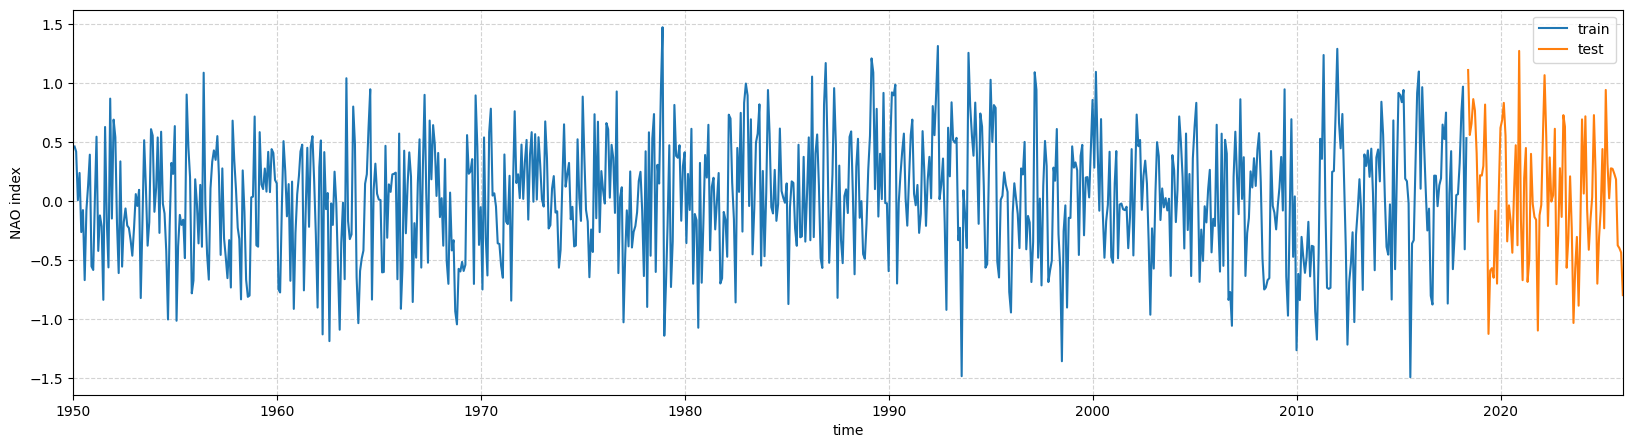

In [62]:
#show train and test data
plt.figure(figsize=[20,5])
plt.plot(train.nao_index_cdas, label = 'train')
plt.plot(test.nao_index_cdas, label = 'test')
plt.xlabel('time')
plt.ylabel('NAO index')
plt.legend()
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2026-01-01'))
plt.show()

## Implementation

First look into the climatology.



In [63]:
climatology = train.groupby(train.index.month).mean()

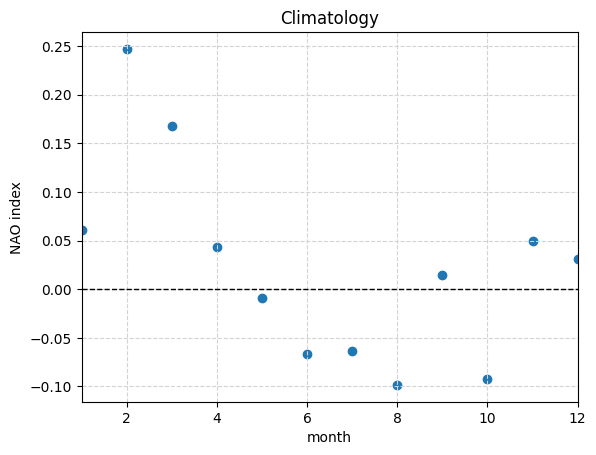

In [65]:
#show climatology
plt.scatter(climatology.month, climatology.nao_index_cdas)
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlabel('month')
plt.ylabel('NAO index')
plt.title('Climatology')
plt.hlines(y=0, xmin=1, xmax=12, linestyle='--', color='black', linewidth=1)
plt.xlim(1,12)
plt.show()

In [66]:
#do the forcast
test_clim_forecast = pd.Series(
    climatology.loc[test.index.month, "nao_index_cdas"].values,
    index=test.index,
    name="nao_index_climatology"
)


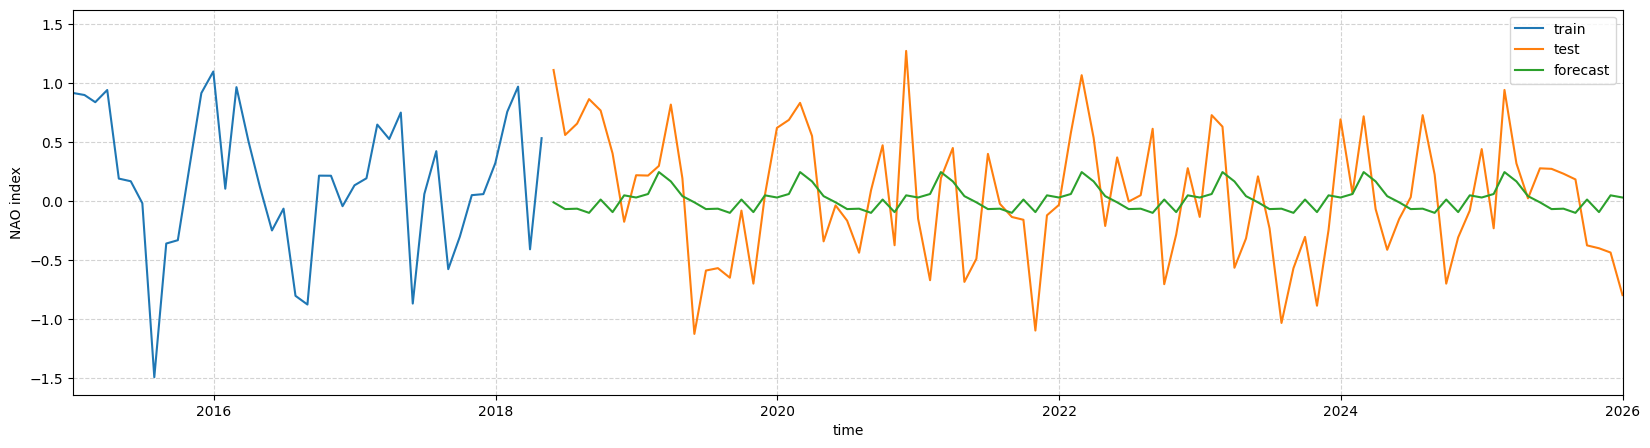

In [67]:
#show train and test data
plt.figure(figsize=[20,5])
plt.plot(train.nao_index_cdas, label = 'train')
plt.plot(test.nao_index_cdas, label = 'test')
plt.plot(test_clim_forecast, label = 'forecast')
plt.xlabel('time')
plt.ylabel('NAO index')
plt.legend()
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2026-01-01'))
plt.show()

## Or do all this with a "real" basline model seasonal ARIMA (SARIMA)

In [36]:
#drop all features apart from the nao index itself
train = train.drop(columns=['month', 'season_flag', 'decade'])
test = test.drop(columns=['month', 'season_flag', 'decade'])

In [37]:
pip install pmdarima

In [38]:
#import model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima


In [39]:
# Find the best SARIMA parameters using auto_arima
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=12,
                            start_P=0, seasonal=True,
                            d=None, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Print the summary of the best model
print(stepwise_model.summary())

# Fit the SARIMA model with the best parameters
best_order = stepwise_model.order
best_seasonal_order = stepwise_model.seasonal_order
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Make predictions
forecast_periods = len(test)
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean

#for time index stuff
forecast_mean.index = test.index
forecast_mean.name = "sarima_forecast"

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=10.79 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1696.319, Time=0.44 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1446.399, Time=1.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1694.326, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1678.491, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1365.205, Time=2.97 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1381.780, Time=3.23 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1366.926, Time=4.03 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1366.937, Time=6.75 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1364.948, Time=3.07 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1446.811, Time=1.27 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   

In [40]:
forecast_mean


,sarima_forecast
time,
2018-05-31,-0.269268
2018-06-30,-0.006886
2018-07-31,-0.610137
2018-08-31,-0.610723
2018-09-30,-0.129716
...,...
2025-08-31,-0.641947
2025-09-30,-0.131053
2025-10-31,0.147093


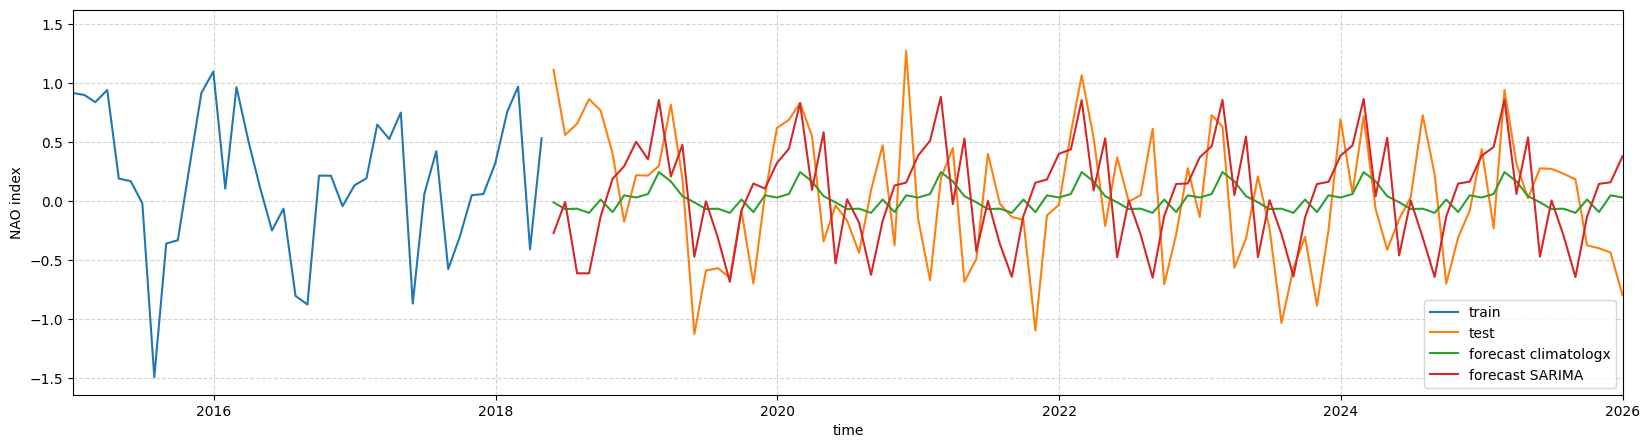

In [47]:
#show train and test data
plt.figure(figsize=[20,5])
plt.plot(train.nao_index_cdas, label = 'train')
plt.plot(test.nao_index_cdas, label = 'test')
plt.plot(test_clim_forecast, label = 'forecast climatologx')
plt.plot(forecast_mean.index, forecast_mean, label="forecast SARIMA")

plt.xlabel('time')
plt.ylabel('NAO index')
plt.legend()
plt.grid(linestyle = '--', color = 'lightgrey')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2026-01-01'))
plt.show()

## Evaluation

mse: Mean squared error

rmse: Root mean squared error

acc: Anomaly Correlation Coefficient: Sign of NAO is maybe more important then difference.



In [57]:
# Evaluate the baseline model

# For a regression problem:
mse_clim = mean_squared_error(test, test_clim_forecast)
mse_SARIMA = mean_squared_error(test, forecast_mean)

rmse_clim = root_mean_squared_error(test, test_clim_forecast)
rmse_SARIMA = root_mean_squared_error(test, forecast_mean)

#Anomaly Correlation Coefficient
acc_clim = np.corrcoef(test_clim_forecast, np.squeeze(test))[0,1] #ACC ~ 1 → perfect match, ACC ~ 0 → no skill, ACC < 0 → anticorrelation. Especially relevant if NAO’s sign matters more than exact value.
acc_SARIMA = np.corrcoef(forecast_mean, np.squeeze(test))[0,1]

In [58]:
print('MSE climatology: ', mse_clim)
print('MSE SARIMA: ', mse_SARIMA)
print('RMSE climatology: ', rmse_clim)
print('RMSE SARIMA: ', rmse_SARIMA)
print('ACC climatology: ', acc_clim)
print('ACC SARIMA: ', acc_SARIMA)

MSE climatology:  0.25262261576722755
MSE SARIMA:  0.38618936871415327
RMSE climatology:  0.5026157734962439
RMSE SARIMA:  0.6214413638583718
ACC climatology:  0.36945355477200065
ACC SARIMA:  0.15522318051988987


I wonder why Sarima is actually showing worse errors here, though in the figure it looks pretty good.